In [23]:
import kahnstatspy.GSLIB as GSLIB
import kahnstatspy.geostats as geostats
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt   
from matplotlib.pyplot import cm 
from scipy.stats import linregress
import seaborn as sns
from scipy import stats
from scipy.stats import zscore

# Load UG90 Excel File

In [2]:
df = pd.read_csv("UG90 PROJECT.csv") #Create a data frame containing UG90 data called df

# Increasing the X and Y coordinates by 0.001
df_mod = df.copy()
df_mod['X'] = df['X'] + 0.001
df_mod['Y'] = df['Y'] + 0.001

### Load Boundary Files

In [3]:
df_lease = pd.read_excel('lease Boundary.xlsx')
df_measured = pd.read_excel('UG2 measured.xlsx')

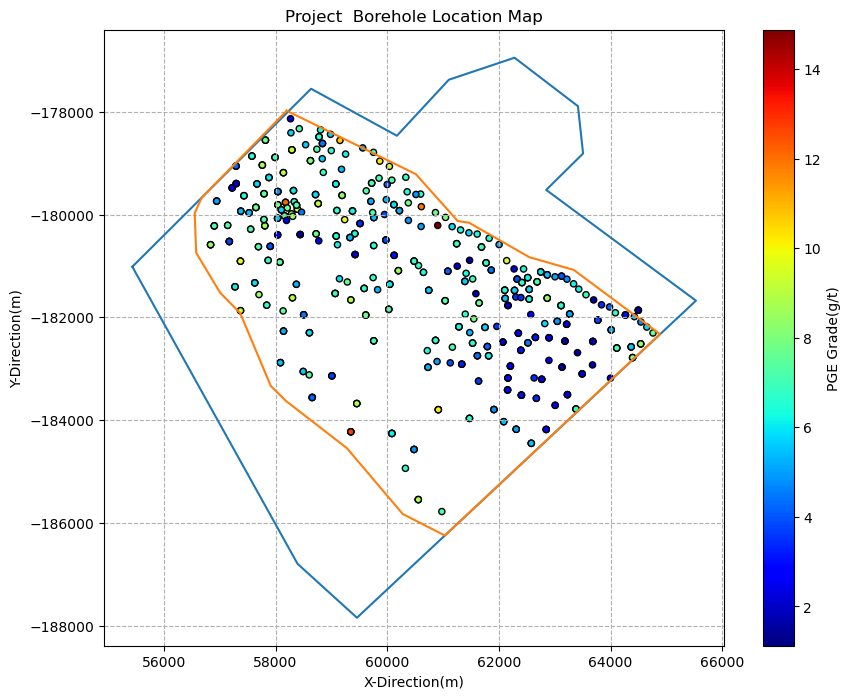

In [29]:
plt.figure(figsize=(10, 8))
plt.scatter(df_mod['X'], df_mod['Y'], c = df_mod['PGE'], s = 20, 
            edgecolors = 'black',cmap = 'jet')
cbar = plt.colorbar()
cbar.set_label("PGE Grade(g/t)", loc = 'center')
plt.title("Project  Borehole Location Map")
plt.xlabel("X-Direction(m)")
plt.ylabel("Y-Direction(m)")
plt.grid(linestyle = '--')
plt.plot(df_lease['X'],df_lease['Y'])
plt.plot(df_measured['X'],df_measured['Y'])
plt.show()

# Point Estimate

### Variogram model parameters

In [7]:
nug = 0.1; nst = 3                                             # 3 nest structure variogram model parameters
it1 = 1; cc1 = 0.15; azi1 = 135; hmaj1 = 200; hmin1 = 200
it2 = 1; cc2 = 0.65; azi2 = 135; hmaj2 = 1000; hmin2 = 800
it3 = 1; cc3 = 0.1;azi3 = 135; hmaj3 = 5000;hmin3 =4500

cv_vario2 = GSLIB.make_variogram3(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2,
                                  it3,cc3,azi3,hmaj3,hmin3) # PGE variogram

xmin = df_measured.X.min(); xmax = df_measured.X.max()              # range of x values
ymin = df_measured.Y.min(); ymax = df_measured.Y.max()   

### Loocv using kb2d_locations

In [8]:
def loocv_kb2d(df, xcol, ycol, vcol, vario_params, tmin, tmax, ndmin, ndmax, radius, ktype, skmean):
    """
    Perform LOOCV with kriging and return RMSE, prediction errors, and a DataFrame of predictions.

    :param df: DataFrame with the spatial data (including 'X', 'Y', and 'PGE' columns)
    :param xcol: Column name for x coordinates in df
    :param ycol: Column name for y coordinates in df
    :param vcol: Column name for the variable of interest in df
    :param vario_params: Variogram model parameters for kb2d_locations
    :param tmin: Property trimming limit (lower)
    :param tmax: Property trimming limit (upper)
    :param ndmin: Minimum number of data points for kriging
    :param ndmax: Maximum number of data points for kriging
    :param radius: Search radius for kriging
    :param ktype: Kriging type
    :param skmean: Simple kriging mean value
    :return: Array of prediction errors, DataFrame of predictions
    """
    prediction_errors = []  # To store the prediction errors
    predictions = []  # To store predictions for each left-out point

    for i in range(len(df)):
        # Separate one location for validation
        validation_point = df.iloc[i]
        df_train = df.drop(i)
        # Prepare df_loc with just the location information for the left-out point
        df_loc = pd.DataFrame([{xcol: validation_point[xcol], ycol: validation_point[ycol]}])

        # Perform kriging for the left-out point
        predicted, _ = geostats.kb2d_locations(
            df=df_train,
            xcol=xcol,
            ycol=ycol,
            vcol=vcol,
            tmin=tmin,
            tmax=tmax,
            df_loc=df_loc,
            xcol_loc=xcol,
            ycol_loc=ycol,
            ndmin=ndmin,
            ndmax=ndmax,
            radius=radius,
            ktype=ktype,
            skmean=skmean,
            vario=vario_params
        )

        # Compute prediction error
        actual_value = validation_point[vcol]
        prediction_error = predicted[0] - actual_value
        prediction_errors.append(prediction_error)
        predictions.append({xcol: validation_point[xcol], ycol: validation_point[ycol], 'Predicted_PGE': predicted[0]})


    # Convert predictions list to DataFrame
    predictions_df = pd.DataFrame(predictions)
    
    return  prediction_errors, predictions_df

In [17]:
residua,predictions_pdf = loocv_kb2d(df_mod,'X','Y','PGE',cv_vario2,-9999.9, 9999.9,12,15,3400,1,0)

Working on location 0
  Estimated   1 blocks 
      average   7.563439616339258  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   8.829864733723065  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   8.130554402638165  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   6.0966000430777765  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   5.911101520961382  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   5.988144911336214  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   5.999259334724311  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   5.740833977194047  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   2.2871766063041017  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   2.2497279144776328  variance  0.0
Working on location 0
  Estimated   1 blocks 
 

Working on location 0
  Estimated   1 blocks 
      average   2.9329186735182167  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   7.2408620888526265  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   7.213513805813785  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   7.320394445863233  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   2.0588738750331914  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   2.050118157883569  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   2.3505457521382334  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.7113393965391572  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.8670416878602365  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   1.6231147777929715  variance  0.0
Working on location 0
  Estimated   1 block

Working on location 0
  Estimated   1 blocks 
      average   8.282271188030178  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   7.801249536651035  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   8.024417894532403  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   8.35910416636229  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   8.55284806235429  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   6.502424776643357  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   10.508879643934218  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   9.91031021036942  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   6.744119637756807  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   6.341599346754057  variance  0.0
Working on location 0
  Estimated   1 blocks 
      

Working on location 0
WARNING KB2D: Singular matrix at location 0 (57371.691, -180906.829)
Working on location 0
WARNING KB2D: Singular matrix at location 0 (57371.710999999996, -180906.97900000002)
Working on location 0
  Estimated   1 blocks 
      average   6.879632519494257  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   6.6747909591739  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   9.074998370529292  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   8.365696376406817  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   6.991075285500758  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   7.268765036290001  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   8.01141542207037  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   7.294833084709196  variance  0.0
Working on location 0
  Estimated   1 blocks

Working on location 0
  Estimated   1 blocks 
      average   5.5577621936821995  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   7.425222355761623  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   8.291286215864758  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   7.682659602966787  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   7.382859117319568  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   8.54893453402668  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   7.601693272164492  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   7.457906821556477  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   11.041645150440681  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   11.287291314476589  variance  0.0
Working on location 0
  Estimated   1 blocks 
  

Working on location 0
  Estimated   1 blocks 
      average   6.355664763731291  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   6.127848855555131  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   6.3689903081384145  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   4.84660911737396  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   5.8882381152705685  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   6.091193689059705  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   5.541116535298753  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   5.001656970530483  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   5.31626104024831  variance  0.0
Working on location 0
  Estimated   1 blocks 
      average   5.552833524900381  variance  0.0
Working on location 0
  Estimated   1 blocks 
    

(array([ 32.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 538.]),
 array([-1008.926     ,  -958.0386212 ,  -907.15124241,  -856.26386361,
         -805.37648482,  -754.48910602,  -703.60172722,  -652.71434843,
         -601.82696963,  -550.93959084,  -500.05221204,  -449.16483324,
         -398.27745445,  -347.39007565,  -296.50269686,  -245.61531806,
         -194.72793927,  -143.84056047,   -92.95318167,   -42.06580288,
            8.82157592]),
 <BarContainer object of 20 artists>)

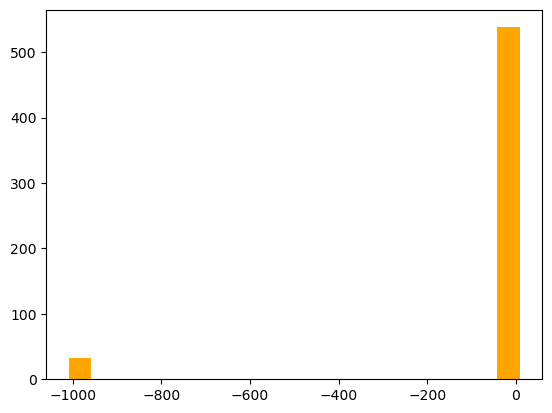

In [12]:
plt.hist(np.array(residuals),bins = 20, color = 'orange')

### Remove outlier (noisey) residuals

In [16]:
df_mod_copy = df_mod.copy()
df_mod_copy = pd.merge(df_mod_copy, predictions_pdf, on=['X', 'Y'], how='left')
df_mod_copy

,BHID,X,Y,Z,DENSITY,PGE,CU,NI,PT,PD,RH,AU,Predicted_PGE
0,WV124D0,64537.971,-182515.439,940.59,4.1604,9.6785,0.0132,0.1229,3.9519,4.9729,0.5590,0.1946,7.563440
1,WV124D1,64537.871,-182515.549,940.65,4.3021,6.9002,0.0072,0.1192,3.8498,2.3939,0.6306,0.0259,8.829865
2,WV124D2,64537.761,-182515.659,940.67,4.1150,8.4249,0.0286,0.1578,4.1353,3.5229,0.5775,0.1891,8.130554
3,WV93ID0,64758.171,-182303.839,1014.90,4.1652,7.5486,0.0112,0.1225,4.3245,2.4174,0.6668,0.1400,6.096600
4,WV94ID0,64647.281,-182189.059,1010.84,4.3862,5.7957,0.0056,0.1169,3.7544,1.4438,0.5633,0.0341,5.911102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,WQ513D1,60217.521,-179924.269,1005.71,4.0264,6.0506,0.0038,0.0900,4.0151,1.5752,0.4318,0.0285,5.215650
572,WQ513D2,60217.431,-179924.189,1005.71,3.9012,5.2359,0.0033,0.0998,3.7575,1.0148,0.4235,0.0400,5.577255
573,WQ527D0,59982.961,-179709.249,1005.80,4.0028,5.3041,0.0062,0.1011,3.5438,1.2130,0.5172,0.0301,5.426842
574,WQ529D0,59951.361,-179998.889,967.06,3.7103,3.8347,0.0054,0.0698,2.6699,0.7602,0.3725,0.0322,5.765226


In [18]:
residuals = df_mod_copy['Predicted_PGE'].values - df_mod_copy['PGE'].values

In [19]:
# Array of residuals
residual = np.array(residuals)  # (Include your residuals array here)

# Calculate the quartiles
Q1 = np.percentile(residual, 25)
Q3 = np.percentile(residual, 75)
IQR = Q3 - Q1

# Determine outliers using 1.5*IQR criteria
outliers = ((residual < (Q1 - 1.5 * IQR)) | (residual > (Q3 + 1.5 * IQR)))

# Print outliers
print("Outliers in the dataset:",residual[outliers])

Outliers in the dataset: [    3.90057829 -1007.0384     -1007.8842     -1005.6186
     3.55528606 -1007.0091     -1005.4025     -1004.9411
     8.82157592     2.74592263 -1001.7961        -2.83866299
    -5.15689105     4.33643834    -2.88639847    -3.25230412
     4.56173267     3.36456418    -7.99637522     4.81137964
     2.90741021    -3.05486084 -1002.381      -1002.1458
     3.15239688    -3.05751037 -1006.3012     -1005.5131
 -1005.5758     -1001.8827     -1003.2613     -1001.7163
    -8.34225619 -1001.61          -2.93570456     3.27533664
 -1004.9842     -1005.1813     -1004.697      -1002.5573
 -1004.0953        -4.03527681    -4.55019649     3.51463129
    -3.55824359 -1004.9009     -1006.2467     -1006.933
 -1007.2414     -1008.926      -1000.9458        -3.41059382
     2.84128107    -2.94970433 -1007.3324     -1005.6664
 -1006.7879     -1007.7193     -1006.3851        -3.68619662
    -2.98558966     4.53547774     4.07804273    -3.05226969
     2.66173415    -4.4443633   

In [20]:
# Determine non-outliers using 1.5*IQR criteria
non_outliers_mask = ~((residual < (Q1 - 1.5 * IQR)) | (residual > (Q3 + 1.5 * IQR)))

# Create a new array without outliers
new_residual = residual[non_outliers_mask]


In [21]:
# Filter the DataFrame to exclude outliers
df_mod_copy_no_outliers = df_mod_copy[non_outliers_mask].copy()

# Optionally, if you want to reset the index
df_mod_copy_no_outliers.reset_index(drop=True, inplace=True)

In [22]:
df_mod_copy_no_outliers

,BHID,X,Y,Z,DENSITY,PGE,CU,NI,PT,PD,RH,AU,Predicted_PGE
0,WV124D0,64537.971,-182515.439,940.59,4.1604,9.6785,0.0132,0.1229,3.9519,4.9729,0.5590,0.1946,7.563440
1,WV124D1,64537.871,-182515.549,940.65,4.3021,6.9002,0.0072,0.1192,3.8498,2.3939,0.6306,0.0259,8.829865
2,WV124D2,64537.761,-182515.659,940.67,4.1150,8.4249,0.0286,0.1578,4.1353,3.5229,0.5775,0.1891,8.130554
3,WV93ID0,64758.171,-182303.839,1014.90,4.1652,7.5486,0.0112,0.1225,4.3245,2.4174,0.6668,0.1400,6.096600
4,WV94ID0,64647.281,-182189.059,1010.84,4.3862,5.7957,0.0056,0.1169,3.7544,1.4438,0.5633,0.0341,5.911102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,WQ513D0,60217.621,-179924.359,1005.52,3.9743,5.0759,0.0040,0.1013,3.6400,1.0090,0.4076,0.0193,5.648447
497,WQ513D1,60217.521,-179924.269,1005.71,4.0264,6.0506,0.0038,0.0900,4.0151,1.5752,0.4318,0.0285,5.215650
498,WQ513D2,60217.431,-179924.189,1005.71,3.9012,5.2359,0.0033,0.0998,3.7575,1.0148,0.4235,0.0400,5.577255
499,WQ527D0,59982.961,-179709.249,1005.80,4.0028,5.3041,0.0062,0.1011,3.5438,1.2130,0.5172,0.0301,5.426842


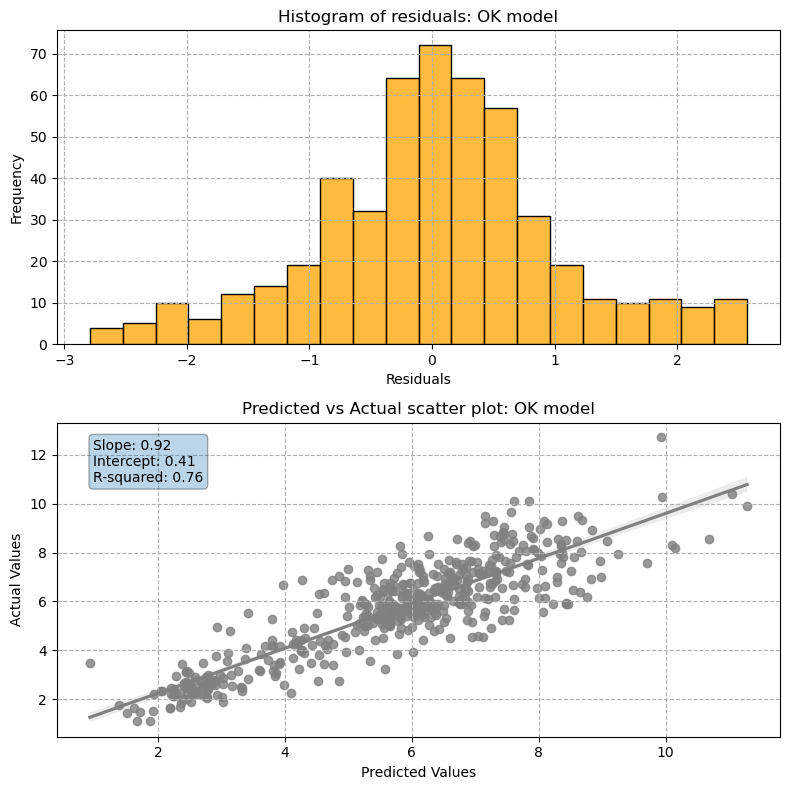

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 3]})

# First subplot for histogram of residuals
sns.histplot(new_residual, kde=False, bins=20, color='orange', ax=axs[0])
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of residuals: OK model')
axs[0].grid(ls='--')

# Second subplot for scatter plot of predicted vs actual values with regression line
sns.regplot(x=df_mod_copy_no_outliers['Predicted_PGE'], y=df_mod_copy_no_outliers['PGE'], color='gray', ax=axs[1])

# Calculate the linear regression values
slope, intercept, r_value, p_value, std_err = stats.linregress(df_mod_copy_no_outliers['Predicted_PGE'], df_mod_copy_no_outliers['PGE'])

# Annotate the slope, intercept, and R-squared on the plot
text = f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR-squared: {r_value**2:.2f}'
axs[1].annotate(text, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', 
                bbox=dict(boxstyle='round', alpha=0.3))

# Set labels and title
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Actual Values')
axs[1].set_title('Predicted vs Actual scatter plot: OK model')
axs[1].grid(ls='--')

# Adjust the layout so titles and labels don't overlap
plt.tight_layout()

# Show the plots
plt.show()